In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731580 entries, 0 to 1731579
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Specific airport

In [4]:
airport = 'KGYY'

In [5]:
airport_name = airport_dict[airport]
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

pickup_df = df[pickup]
dropoff_df = df[dropoff]

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal]
transfer_df = all_df[transfer]

all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Pickups'
dropoff_df.name = 'Dropoffs'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID', 'MissionID']].nunique()

weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()

unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = round(unique_removals / total_unique * 100, 2)
transfer_percent = round(unique_transfers / total_unique * 100, 2)
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

In [7]:
def airport_report(airport=str, print_report=False):
    airport = airport
    if airport.upper() in airport_dict.keys():
        pass
    else:
        print(f'{airport} not represented in dataset')
    airport_name = airport_dict[airport]
    pickup = df['PULOC'] == airport
    dropoff = df['DropLoc'] == airport

    pickup_df = df[pickup]
    dropoff_df = df[dropoff]

    first_pickup = pickup_df.MissionDate.min()
    last_pickup = pickup_df.MissionDate.max()
    first_dropoff = dropoff_df.MissionDate.min()
    last_dropoff = dropoff_df.MissionDate.max()

    pickup_df.set_index('MissionDate', inplace=True)
    dropoff_df.set_index('MissionDate', inplace=True)

    all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

    removal = all_df['R-T'] == 'R'
    transfer = all_df['R-T'] == 'T'
    removal_df = all_df[removal]
    transfer_df = all_df[transfer]

    all_df.name = 'Passengers'
    removal_df.name = 'Removals'
    transfer_df.name = 'Transfers'
    pickup_df.name = 'Pickups'
    dropoff_df.name = 'Dropoffs'

    # This grouped table would work for mapping flights from specific airports.
    all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID', 'MissionID']].nunique()
    
    weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
    weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
    monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
    monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
    monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
    monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
    annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
    annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
    
    unique_pickups = len(set(pickup_df['AlienMasterID']))
    unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
    unique_removals = len(set(removal_df['AlienMasterID']))
    unique_transfers = len(set(transfer_df['AlienMasterID']))
    total_unique = len(set(all_df['AlienMasterID']))
    removal_percent = round(unique_removals / total_unique * 100, 2)
    transfer_percent = round(unique_transfers / total_unique * 100, 2)
    monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
    monthly_pickup_avg = round(monthly_pickups.mean(), 2)
    monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
    monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
    unique_pickup_missions = len(set(pickup_df['MissionID']))
    unique_dropoff_missions = len(set(dropoff_df['MissionID']))
    
    airport_vars = {airport:
                {'airport_name': airport_name,
                'unique_pickups': unique_pickups,
                'unique_dropoffs': unique_dropoffs,
                'unique_removals': unique_removals,
                'unique_transfers': unique_transfers,
                'total_unique': total_unique,
                'removal_percent': removal_percent,
                'transfer_percent': transfer_percent,
                'monthly_dropoff_avg': monthly_dropoff_avg,
                'monthly_pickup_avg': monthly_pickup_avg,
                'monthly_dropoff_mission_avg': monthly_dropoff_mission_avg,
                'monthly_pickup_mission_avg': monthly_pickup_mission_avg,
                'unique_pickup_missions': unique_pickup_missions,
                'unique_dropoff_missions': unique_dropoff_missions}}
    
    row = pd.DataFrame(airport_vars).T
    
    if print_report == True:
        print(f'{airport} ({airport_name})')
        print(f'---------------------------------------------------------')
        print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
        print(f'{unique_removals} removals, {unique_transfers} transfers.')
        print(f"{total_unique} total unique passengers.")
        print(f"{removal_percent}% removals, {transfer_percent}% transfers")
        print(f'{monthly_dropoff_avg} average dropoffs per month.')
        print(f'{monthly_pickup_avg} average pickups per month.')
        print()
        print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
        print(f"{all_df['MissionID'].nunique()} total missions.")
        print(f'{monthly_dropoff_mission_avg} average dropoff missions per month.')
        print(f'{monthly_pickup_mission_avg} average pickup missions per month.')
        print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
        print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')

    return(row)

In [9]:
airport_report(airport, print_report=True)

KGYY (Gary Chicago International Airport)
---------------------------------------------------------
17876 passengers picked up, 8376 passengers dropped off.
7349 removals, 18903 transfers.
26252 total unique passengers.
27.99% removals, 72.01% transfers
126.91 average dropoffs per month.
270.85 average pickups per month.

322 pickup missions, 269 dropoff missions.
343 total missions.
4.08 average dropoff missions per month.
4.88 average pickup missions per month.
First pickup mission: 2013-06-19 00:00:00; Last pickup flight: 2018-11-30 00:00:00
First dropoff mission: 2013-06-19 00:00:00; Last dropoff mission: 2018-11-30 00:00:00


,airport_name,monthly_dropoff_avg,monthly_dropoff_mission_avg,monthly_pickup_avg,monthly_pickup_mission_avg,removal_percent,total_unique,transfer_percent,unique_dropoff_missions,unique_dropoffs,unique_pickup_missions,unique_pickups,unique_removals,unique_transfers
KGYY,Gary Chicago International Airport,126.91,4.08,270.85,4.88,27.99,26252,72.01,269,8376,322,17876,7349,18903


# Annual trends (by fiscal year)

In [45]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True);

In [46]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Pickup Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total': annual_total})

In [47]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

annual_pickups.index = annual_pickups.index.year+1 
annual_pickups.index.name = 'Fiscal Year'

annual_dropoffs.index = annual_dropoffs.index.year+1 
annual_dropoffs.index.name = 'Fiscal Year'

In [48]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [51]:
annual_pickups

Fiscal Year
2013     531
2014    4195
2015    2842
2016    2872
2017    3603
2018    3205
2019     628
Name: Total pickups, dtype: int64

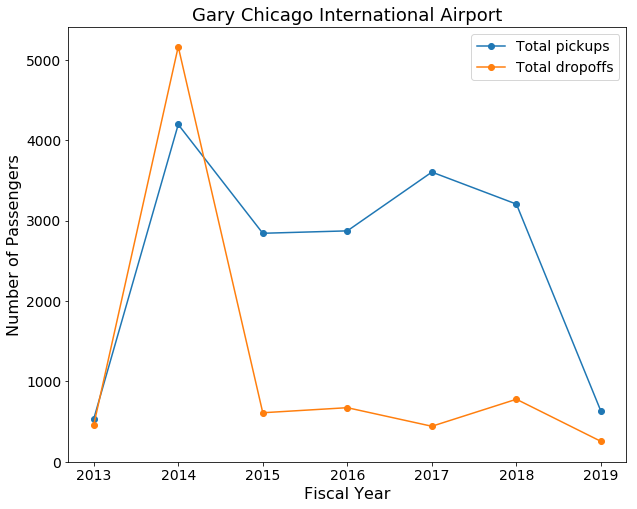

In [54]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
#     ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/figures/{airport}-ICE-Air-Passengers.png', dpi=100)
    return fig, ax
    plt.cla(ax)
    plt.close(fig)

plot = pickup_dropoff_trend([annual_pickups, annual_dropoffs]);

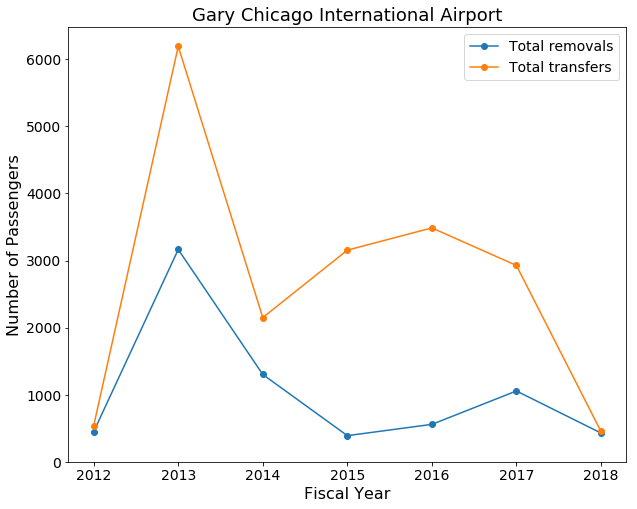

In [55]:
def removal_transfer_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
#     ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/figures/{airport}-ICE-Air-Removals-Transfers.png', dpi=100)
    return fig, ax
    plt.cla(ax)
    plt.close(fig)

plot = removal_transfer_trend([annual_removals,
                               annual_transfers]);

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [16]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [17]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

In [18]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

ValueError: Length mismatch: Expected axis has 6 elements, new values have 8 elements

# Monthly averages (by calendar year)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

Is this correct though? What we do below is calculate the mean of the monthly means for each year, which may not be right. We can just divide the yearly total by number of months to get monthly average.

Mean of means appears to be equivalent to total/number of months; at least it deals effectively with partial years.

In [19]:
pickup_df.groupby(pd.Grouper(freq='AS-OCT'))['AlienMasterID'].nunique()['2010':'2017']/12

MissionDate
2012-10-01     44.250000
2013-10-01    349.583333
2014-10-01    236.833333
2015-10-01    239.333333
2016-10-01    300.250000
2017-10-01    267.083333
Freq: AS-OCT, Name: AlienMasterID, dtype: float64

In [20]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

KeyError: '2010'

In [21]:
monthly_means.round(2)

""


In [22]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [23]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                13664
GUATEMALA              1571
HONDURAS               1210
EL SALVADOR             743
HAITI                   172
NICARAGUA               101
ECUADOR                  75
COLOMBIA                 45
DOMINICAN REPUBLIC       41
JAMAICA                  39
Name: CountryOfCitizenship, dtype: int64

In [24]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

HONDURAS       2407
EL SALVADOR    2335
GUATEMALA      1899
MEXICO          323
CUBA            182
Name: CountryOfCitizenship, dtype: int64

In [25]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         13987
HONDURAS        3617
GUATEMALA       3470
EL SALVADOR     3078
HAITI            336
Name: CountryOfCitizenship, dtype: int64

In [26]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [27]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [28]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [29]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [30]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = all_df.copy()
df_to_analyze.name = all_df.name

In [31]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [32]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [56]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [57]:
all_passenger_nationality_by_year

AlienMasterID                                            \
CountryOfCitizenship      CAMBODIA CHINA COLOMBIA DOMINICAN REPUBLIC ECUADOR   
FY                                                                             
2012-10-01                     1.0   1.0      2.0                1.0     4.0   
2013-10-01                     2.0  63.0      4.0               10.0    91.0   
2014-10-01                     NaN   5.0     10.0                6.0    22.0   
2015-10-01                     4.0  36.0     11.0               17.0    12.0   
2016-10-01                     NaN  39.0     14.0                8.0    21.0   
2017-10-01                    10.0  32.0      9.0               15.0    26.0   

                                                                      ...      \
CountryOfCitizenship EL SALVADOR GUATEMALA HONDURAS INDIA  MEXICO     ...       
FY                                                                    ...       
2012-10-01                 160.0     172.0    176.0   5.0   452.0     ...       
2013-10-01                1952.0    1534.0   2161.0  10.0  3360.0     ...       
2014-10-01                 215.0     514.0    233.0   5.0  2406.0     ...       
2015-10-01                 284.0     307.0    284.0  40.0  2331.0     ...       
2016-10-01                 129.0     351.0    271.0  41.0  2677.0     ...       
2017-10-01                 266.0     504.0    421.0  58.0  2319.0     ...       

                                                                         \
CountryOfCitizenship TRINIDAD & TOBAGO BURMA TOGO UZBEKISTAN AZERBAIJAN   
FY                                                                        
2012-10-01                         NaN   NaN  NaN        NaN        NaN   
2013-10-01                         NaN   NaN  NaN        NaN        NaN   
2014-10-01                         NaN   NaN  NaN        NaN        NaN   
2015-10-01                         NaN   NaN  NaN        NaN        NaN   
2016-10-01                         1.0   1.0  NaN        NaN        NaN   
2017-10-01                         NaN   2.0  1.0        3.0        1.0   

                                                                  
CountryOfCitizenship TANZANIA CONGO ANGOLA KYRGYSTAN SOUTH SUDAN  
FY                                                                
2012-10-01                NaN   NaN    NaN       NaN         NaN  
2013-10-01                NaN   NaN    NaN       NaN         NaN  
2014-10-01                NaN   NaN    NaN       NaN         NaN  
2015-10-01                NaN   NaN    NaN       NaN         NaN  
2016-10-01                NaN   NaN    NaN       NaN         NaN  
2017-10-01                1.0   1.0    1.0       1.0         1.0  

[6 rows x 96 columns]

In [34]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [35]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

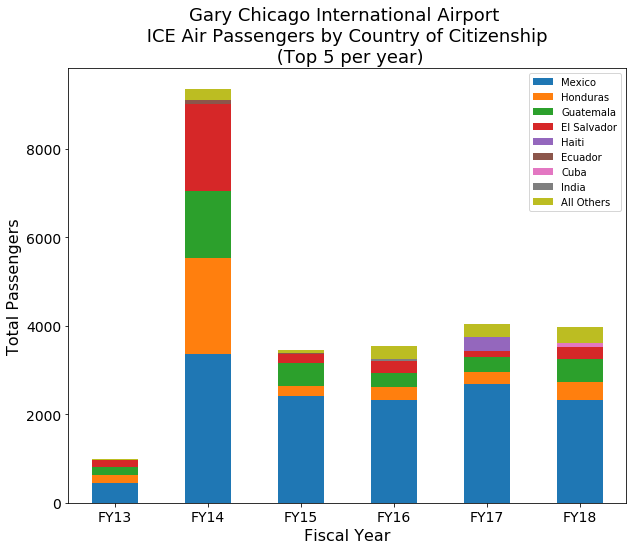

In [36]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [37]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary set of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [ ]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [ ]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)

In [ ]:
# Select arbitrary number of top values to display here
number_of_top_values = 6
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

In [ ]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air {df_to_analyze.name} at {airport} by Country of Citizenship',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [ ]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [ ]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [ ]:
juvenile_pickups

In [ ]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [ ]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

# Detainee status

In [ ]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [ ]:
status = pd.read_csv('../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

problematic = ['2A', '2B', '5C', '5D', '5E', '5F', '8A', '8B', '8D', '8G', '8H', '11']

In [ ]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

In [ ]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [ ]:
total

# Airport report

For a each airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [ ]:
airport_df = pd.DataFrame()
for key in airport_dict.keys():
    try:
        row = airport_report(key)
    except AttributeError:
        pass
    airport_df = airport_df.append(row)
airport_df.to_csv('../output/all_airport_vars.csv')

In [ ]:
airport_df